non_vlass_incoherent.pkl -> 8,575,202 hits
non_vlass_other.pkl -> 11,482,838 hits
non_vlass_phase_center.pkl -> 7,350,331 hits
vlass_incoherent.pkl -> 98,718 hits
vlass_other.pkl -> 638,961 hits
vlass_phase_center.pkl -> 1735 hits

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from umap import UMAP
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import KLDivergence
import seaborn as sns
import random
import os
import time


/home/jaym/jay-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
plt.figure(figsize=(10,6))


<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [3]:
def plot(X_umap, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    labels = labels if labels is not None else np.ones(X_umap.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X_umap.shape[0])

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X_umap[ci, 0],
                X_umap[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()


In [8]:
# Prepare data
features = [
    'beam_id',
    'ra_hours',
    'dec_degrees',
    'signal_frequency',
    'signal_beam',
    'signal_drift_rate',
    'signal_snr',
    'signal_power',
    'signal_incoherent_power',
]

pd.set_option('display.max_columns', None)
df = pd.read_pickle("../data/clean_df.pkl")
df_shuffled = df.sample(frac=1)

In [9]:
def cluster(start_index, end_index, dataframe, seed, graph=True):
    # set random seeds for consistency
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    K.clear_session()

    # take a slice of the original dataframe for clustering (3000 recommended)
    df_sliced = dataframe[start_index:end_index].copy()

    df_subset = df_sliced[features]

    # scale the subset dataframe
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_subset)

    # Build autoencoder
    input_dim = X_scaled.shape[1]
    encoding_dim = 4

    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(16, activation='relu')(input_layer)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    decoded = layers.Dense(16, activation='relu')(encoded)
    decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = models.Model(inputs=input_layer, outputs=decoded)
    encoder = models.Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, shuffle=True, verbose=0)

    # encode the dataframe subset
    X_encoded = encoder.predict(X_scaled)

    # Run HDBSCAN clustering
    clusterer = HDBSCAN(min_cluster_size=10, n_jobs=-1)
    clusterer.fit(X_encoded)

    labels = clusterer.labels_
    probabilities = getattr(clusterer, "probabilities_", None)
    """
    # Add labels and probabilities to original subset
    df_sliced['cluster_label'] = labels
    if probabilities is not None:
        df_sliced['cluster_probability'] = probabilities
    """
    # Optional: visualize
    if graph:
        umap_model = UMAP(n_components=2, random_state=seed)
        X_umap = umap_model.fit_transform(X_encoded)
        plot(X_umap, labels, probabilities)
    
    return np.sum(labels == -1)

    #return df_sliced


In [ ]:
# testing clustering 3000 points at a time 10 times vs 30000 points
start_time = time.perf_counter()
three_thousand_data_outliers = 0
for i in range(0, 27001, 3000):
    print(f'Clustering rows {i} to {i+3000}...')
    three_thousand_data_outliers += cluster(i, i + 3000, df, 50, graph=False)
    print('Finished')
end_time = time.perf_counter()
three_thousand_time = end_time - start_time

start_time = time.perf_counter()
print(f'Clustering rows 0 to 30000...')
thirty_thousand_rows_outliers = cluster(0, 30000, df, 50, graph=False)
print('Finished')
end_time = time.perf_counter()
thirty_thousand_time = end_time - start_time

print(f'30000 points clustered 3000 points at a time number of outliers: {three_thousand_data_outliers} -> took {three_thousand_time} seconds')
print(f'30000 points clustered together number of outliers: {thirty_thousand_rows_outliers} -> took {thirty_thousand_time} seconds')

Clustering rows 0 to 3000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Finished
Clustering rows 3000 to 6000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Finished
Clustering rows 6000 to 9000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Finished
Clustering rows 9000 to 12000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Finished
Clustering rows 12000 to 15000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Finished
Clustering rows 15000 to 18000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Finished
Clustering rows 18000 to 21000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Finished
Clustering rows 21000 to 24000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Finished
Clustering rows 24000 to 27000...


2214/2214 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step


/home/jaym/jay-env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score (Real): -0.057
Silhouette Score (Random): -0.076


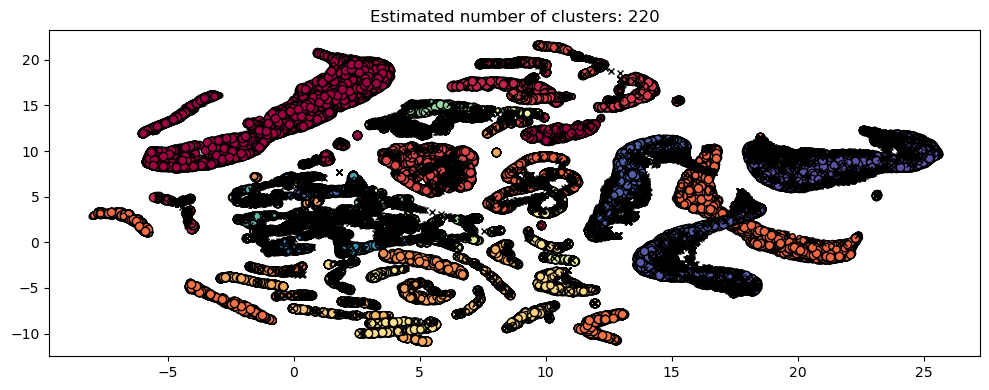

In [22]:
clustered_df = cluster(0, df.shape[0] - 1, df, 50, graph=True)

Text(0.5, 1.0, 'Cluster Membership Strength')

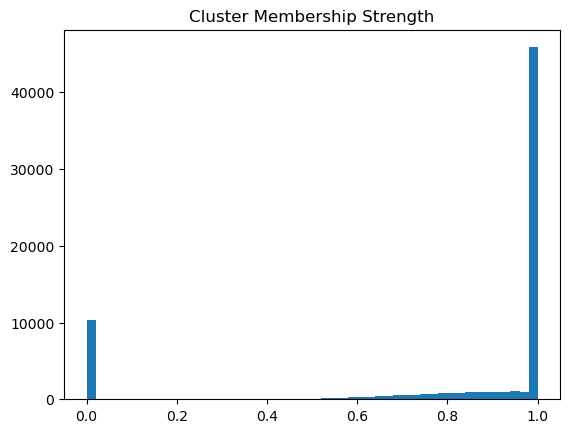

In [23]:
plt.hist(clustered_df['cluster_probability'], bins=50)
plt.title("Cluster Membership Strength")

Text(0.5, 1.0, 'Cluster Size Distribution')

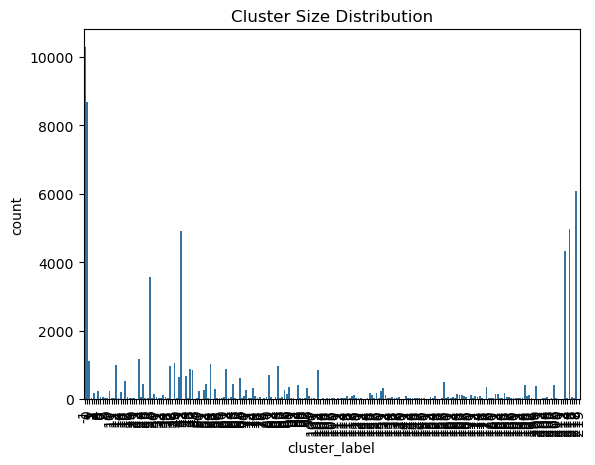

In [ ]:
sns.countplot(x=clustered_df['cluster_label'])
plt.xticks(rotation=90)
plt.title('Cluster Size Distribution')

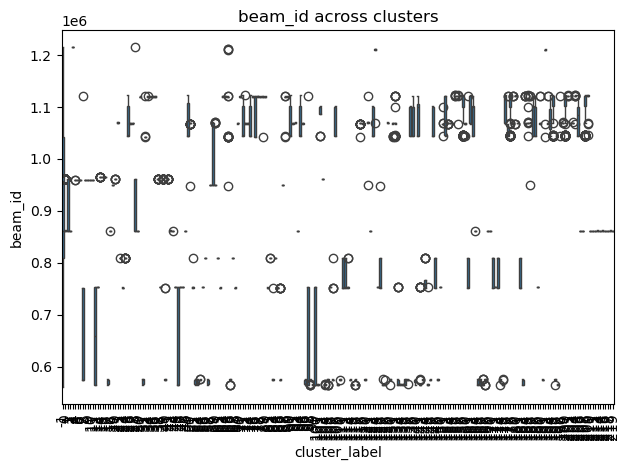

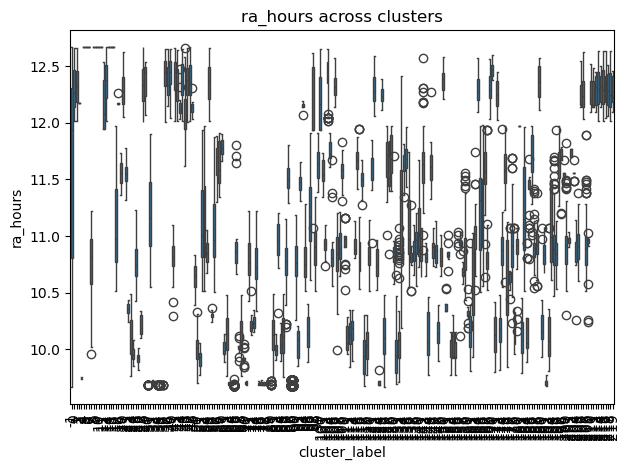

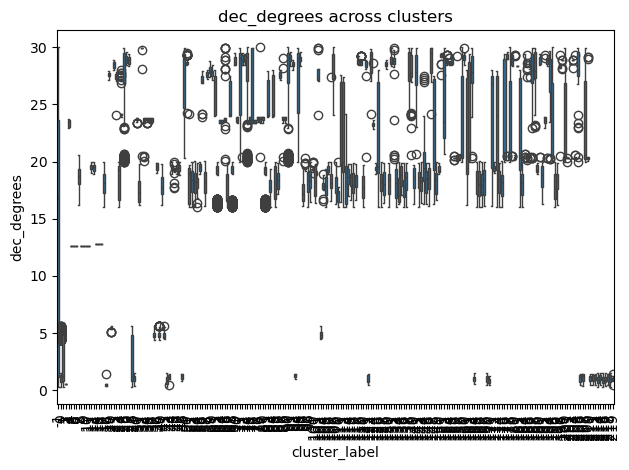

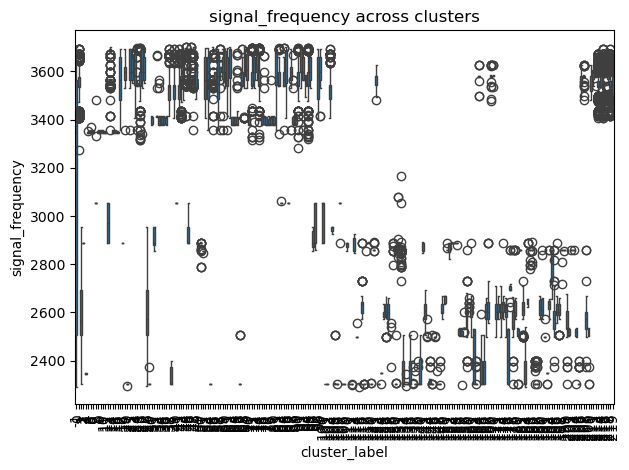

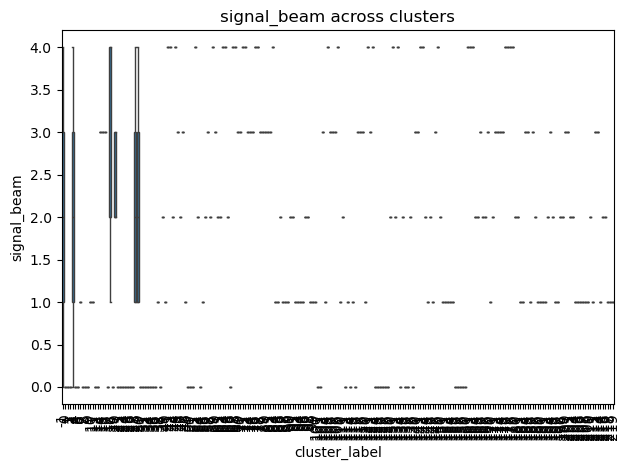

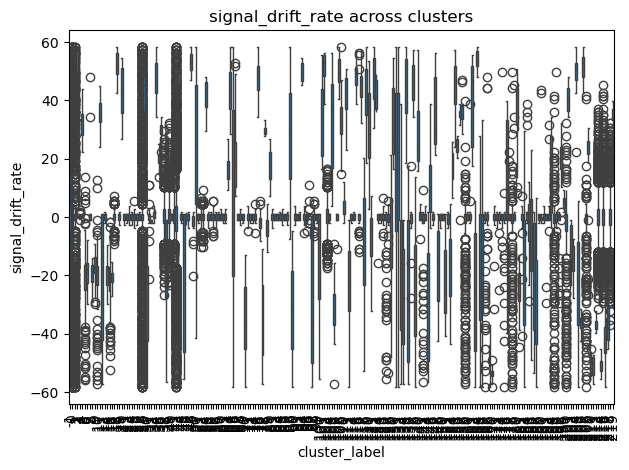

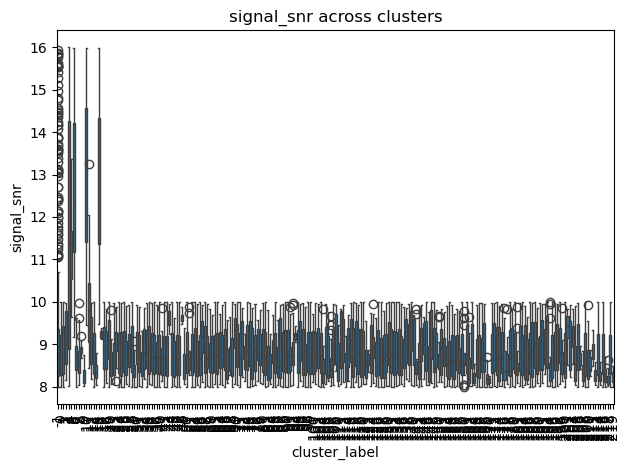

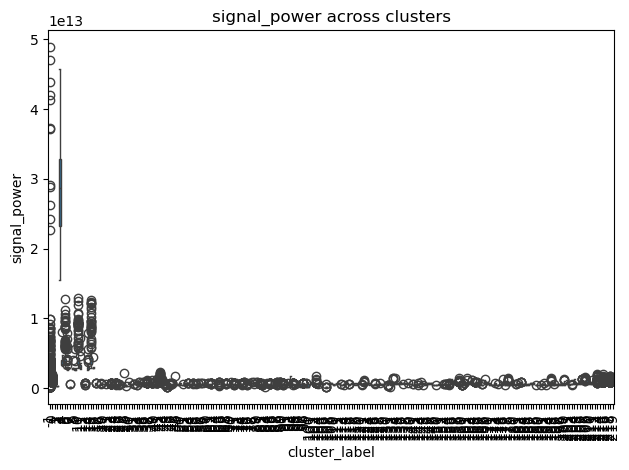

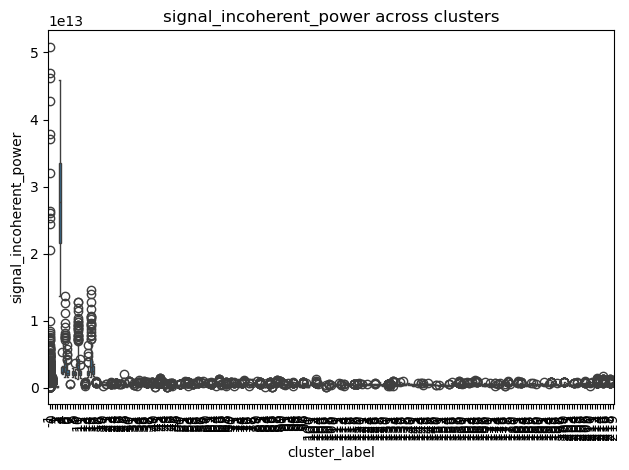

In [26]:
for feature in features:
    sns.boxplot(data=clustered_df, x='cluster_label', y=feature)
    plt.title(f'{feature} across clusters')
    plt.xticks(rotation=90)  # optional, helps if you have many clusters
    plt.tight_layout()
    plt.show()

In [13]:
print(clustered_df['beam_id'].nunique())
clustered_df[clustered_df['cluster_label'] == 1].shape


10129


(1115, 28)

In [8]:
outliers = clustered_df[clustered_df['cluster_label'] == -1]

In [11]:
outliers.shape

(10290, 28)

# Tracking results of clustering based on random seed for points 0 - 21000 with batch sizes of 3000
Seed = 100:
 - 356
 - 248
 - 566
 - 3
 - 577
 - 1120
 - 1

Seed = 42:
 - 481
 - 280
 - 486
 - 8
 - 412
 - 0
 - 552


In [ ]:
# testing clustering 3000 points at a time 10 times vs 30000 points
start_time = time.perf_counter()
three_thousand_data_outliers = 0
for i in range(0, 69001, 3000):
    print(f'Clustering rows {i} to {i+3000}...')
    three_thousand_data_outliers += cluster(i, i + 3000, df, 50, graph=False)
    print('Finished')
end_time = time.perf_counter()
three_thousand_time = end_time - start_time

start_time = time.perf_counter()
print(f'Clustering rows 0 to 72000...')
thirty_thousand_rows_outliers = cluster(0, 72000, df, 50, graph=False)
print('Finished')
end_time = time.perf_counter()
thirty_thousand_time = end_time - start_time

print(f'30000 points clustered 3000 points at a time number of outliers: {three_thousand_data_outliers} -> took {three_thousand_time} seconds')
print(f'30000 points clustered together number of outliers: {thirty_thousand_rows_outliers} -> took {thirty_thousand_time} seconds')

"""
# testing how random seeds affect clustering performance
print("Same data different random seed (seed=100 -> seed=42)")
cluster(15000, 18000, df, 100)
cluster(15000, 18000, df, 42)

# testing the idec autoencoder
print("Same data different random seed with idec (seed=100 -> seed=42)")
cluster_with_idec(0, 30000, df, 100)
cluster_with_idec(0, 30000, df, 42)
"""
print('', end='')

Clustering rows 0 to 3000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 3000 to 6000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 6000 to 9000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 9000 to 12000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 12000 to 15000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 15000 to 18000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 18000 to 21000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 21000 to 24000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 24000 to 27000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 27000 to 30000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 30000 to 33000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 33000 to 36000...
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Finished
Clustering rows 36000 to 3